# Calculate embeddings using insight face model

[link](https://github.com/TreB1eN/InsightFace_Pytorch)

In [3]:
import os, sys
import importlib

In [2]:
project_dir = os.path.realpath('..')
print(project_dir)
if project_dir not in sys.path: sys.path.insert(0, project_dir)

/home/neuro/RG/juul/process


In [4]:
%load_ext autoreload

%autoreload 2

### Load a pre-trained model

In [11]:
import torch

In [7]:
insight = importlib.import_module('notebooks.insightface_model', project_dir)

In [8]:
!ls ../models/external

frozen_inference_graph_face.pb	     model_ir_se50.pth
haarcascade_eye.xml		     resnet50_ft_weight.pkl
haarcascade_frontalface_default.xml


In [12]:
model_path = '../models/external/model_ir_se50.pth'

In [13]:
model = insight.Backbone(50, 0, mode='ir_se').cuda()


model.load_state_dict(torch.load(model_path))

model.eval()

Backbone(
  (input_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
  )
  (output_layer): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0)
    (2): Flatten()
    (3): Linear(in_features=25088, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (body): Sequential(
    (0): bottleneck_IR_SE(
      (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): PReLU(num_parameters=64)
        (3): Conv2d(64, 64, 

### Image loader

##### create dataset

In [27]:
from torch.utils.data import DataLoader, Dataset

In [32]:
utils = importlib.import_module('src.utils', project_dir)
train_utils = importlib.import_module('src.age_gender.train_utils', project_dir)
plot = importlib.import_module('src.rgutils.plot', project_dir)

In [25]:
detections = '../data/interim/embeddings/juul0807_mtcnn.hdf5'

In [34]:
class FaceDataset(Dataset):
    def __init__(self, detections_path, model_input_size, transforms=None):
        self.image_paths = utils.load_hdf(detections, keys=['image_paths'])['image_paths']
        self.image_paths = [p.decode('utf-8') for p in self.image_paths]
        self.model_input_size = model_input_size
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = train_utils.load_convert_resize(path, self.model_input_size)
        if self.transforms:
            image = self.transforms(image)
        return image

In [35]:
face_dataset = FaceDataset(detections, (112,112))

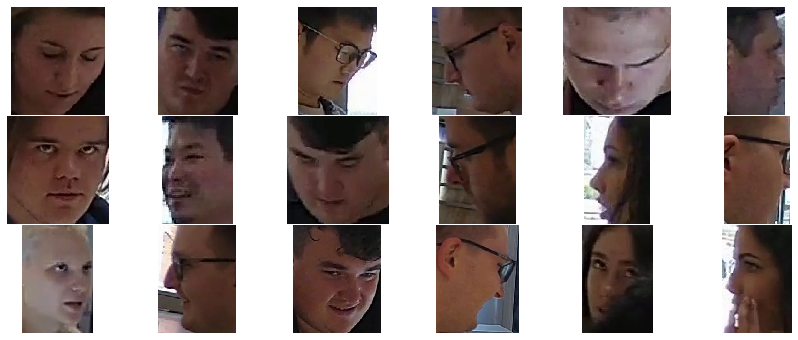

In [36]:
plot.show_images(face_dataset.image_paths, 3, 6, fig_dims=(15,6))

##### Create data loader

In [39]:
from torchvision import transforms

In [54]:
batch_size = 256
num_jobs = 4

In [42]:
# normalization from here https://github.com/TreB1eN/InsightFace_Pytorch/blob/master/data/data_pipe.py
input_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5,0.5,0.5]),
])

In [186]:
face_dataset = FaceDataset(detections, (112,112), input_transforms)

In [187]:
face_loader = DataLoader(face_dataset, batch_size=batch_size, shuffle=False, num_workers=num_jobs)

In [188]:
for x in face_loader:
    print(x.size())
    print(x.mean(), x.std())
    print(x.dtype)
    break

torch.Size([256, 3, 64, 64])
tensor(-0.5249) tensor(0.2850)
torch.float32


### Calculate embeddings

In [56]:
from tqdm import tqdm
import numpy as np

In [53]:
embeddings = []

with torch.no_grad():
    for x in tqdm(face_loader, desc='Face batches'):
        out = model(x.cuda())
        embeddings.extend(out.cpu().numpy())

Face batches: 100%|██████████| 2869/2869 [05:56<00:00,  8.10it/s]


In [57]:
embeddings = np.array(embeddings)
embeddings.shape

(183610, 512)

In [58]:
save_embeddings = '../data/interim/embeddings/juul0807_insightface_irse50.hdf5'

In [59]:
utils.create_hdf(save_embeddings, {'embeddings': embeddings},)

### Explore mean and std

In [61]:
%matplotlib inline

import matplotlib.pyplot as plt

In [60]:
means = embeddings.mean(1)
stds = embeddings.std(1)

means.shape, stds.shape

((183610,), (183610,))

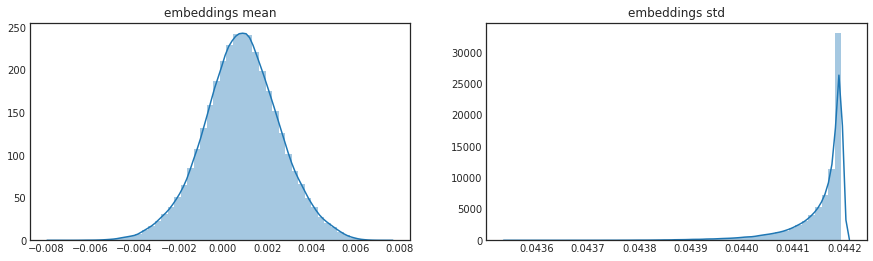

In [63]:
plot.histograms({'embeddings mean': means, 'embeddings std': stds}, 1, 2, fig_dims=(15,4))

##### Visualize combinations

- low mean and low std
- high mean and low std

In [92]:
image_paths = np.array(face_dataset.image_paths)

In [136]:
def filter_images(by_mean=None, by_std=None):
    assert by_mean is not None or by_std is not None
    if by_mean:
        if by_mean['mode'] == 'low':
            indices_m = np.argwhere(means < by_mean['bound']).squeeze(1)
        elif by_mean['mode'] == 'high':
            indices_m = np.argwhere(means > by_mean['bound']).squeeze(1)
        else:
            raise Exception('wrong keyword')
    else:
        indices_m = np.arange(len(image_paths))
    if by_std:
        if by_std['mode'] == 'low':
            indices_s = np.argwhere(stds < by_std['bound']).squeeze(1)
        elif by_mean['mode'] == 'high':
            indices_s = np.argwhere(stds > by_std['bound']).squeeze(1)
        else:
            raise Exception('wrong keyword')  
    else:
        indices_s = np.arange(len(image_paths))
    indices = np.intersect1d(indices_m, indices_s)
    print('Mean filter', len(indices_m), 'Std filter', len(indices_s), 'Intersection', len(indices))
    paths = image_paths[indices]
    if by_mean:
        labels = [f'{means[i]:.4f}' for i in indices]
    else:
        labels = [f'{stds[i]:.4f}' for i in indices]
    return list(zip(paths,labels))

##### low mean

In [144]:
mean_lower = -0.004

In [145]:
low_mean = filter_images(by_mean={'mode': 'low',
                                  'bound': mean_lower})

Mean filter 732 Std filter 183610 Intersection 732


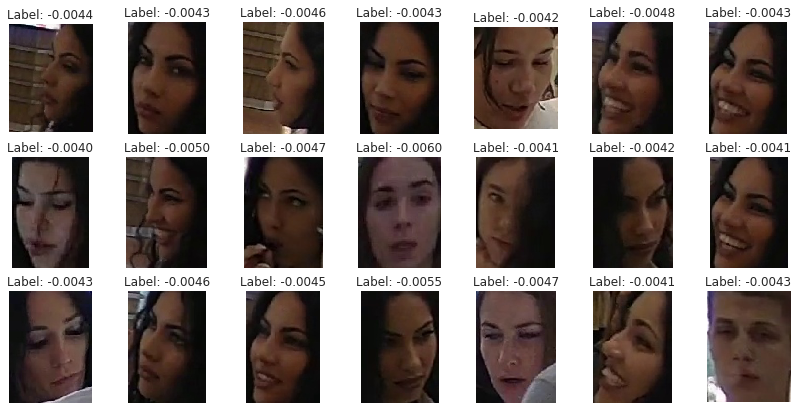

In [147]:
plot.image_labels_grid(3, 7, low_mean, fig_dims=(14, 7), height_space=0.2)

> low mean correlated with ladies

###### high mean

In [159]:
mean_upper = 0.005

In [160]:
high_mean = filter_images(by_mean={'mode': 'high', 'bound': mean_upper})

Mean filter 1577 Std filter 183610 Intersection 1577


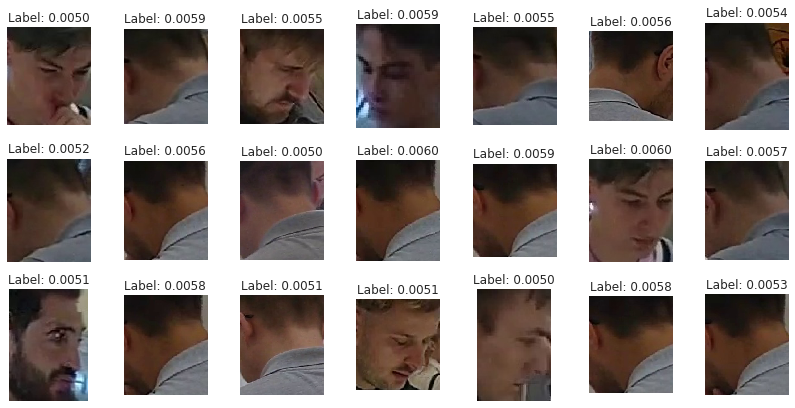

In [161]:
plot.image_labels_grid(3, 7, high_mean, fig_dims=(14, 7), height_space=0.2)

> high mean partly related to false detections and low quality

##### Low std

In [167]:
std_lower = 0.0439

In [168]:
low_std = filter_images(by_std={'mode': 'low', 'bound': std_lower})

Mean filter 183610 Std filter 1398 Intersection 1398


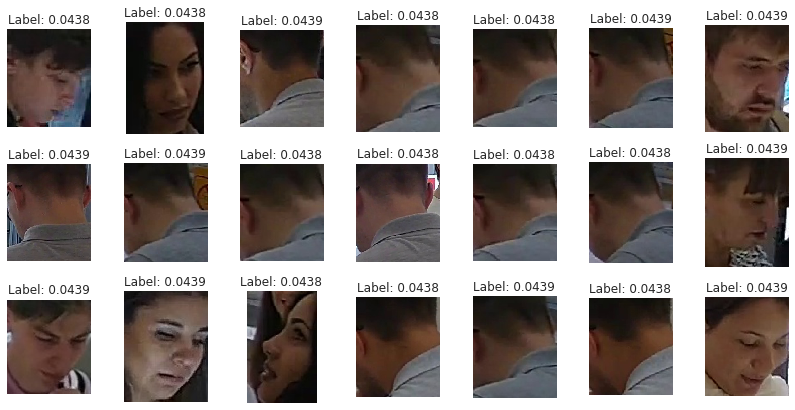

In [170]:
plot.image_labels_grid(3, 7, low_std, fig_dims=(14, 7), height_space=0.2)

> low standard deviation partly related to false detections

##### low mean and low std

In [175]:
mean_lower = -0.0039
std_lower = 0.044

In [176]:
low_low = filter_images(by_mean={'mode': 'low', 'bound': mean_lower},
                        by_std={'mode': 'low', 'bound': std_lower})

Mean filter 832 Std filter 6092 Intersection 593


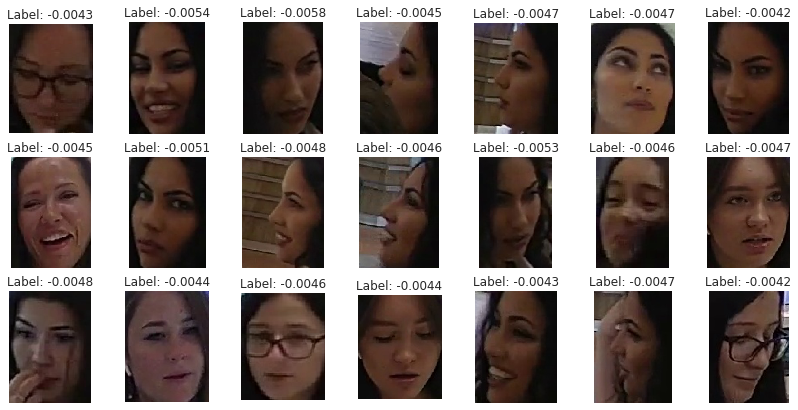

In [177]:
plot.image_labels_grid(3, 7, low_low, fig_dims=(14, 7), height_space=0.2)

> it's ok

##### high mean and low std

In [195]:
mean_upper = 0.0054
std_lower = 0.0438

In [196]:
high_low = filter_images(by_mean={'mode': 'high', 'bound': mean_upper},
                        by_std={'mode': 'low', 'bound': std_lower})

Mean filter 658 Std filter 208 Intersection 192


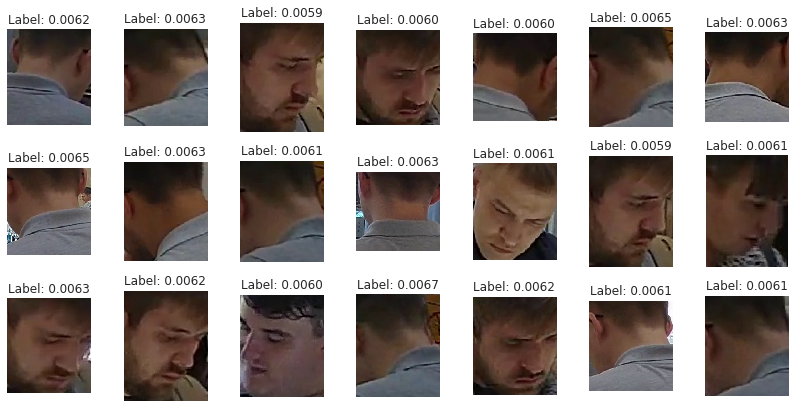

In [197]:
plot.image_labels_grid(3, 7, high_low, fig_dims=(14, 7), height_space=0.2)

> high mean and low std are related many false detections